# Graduate Admission
Graduate Admission data is obtained from https://www.kaggle.com/mohansacharya/graduate-admissions.  

**Context**: This dataset is created for prediction of Graduate Admissions from an Indian perspective.  
**Content**: The dataset contains several parameters which are considered important during the application for Masters Programs. The parameters included are:
1. GRE Scores (out of 340) 
2. TOEFL Scores (out of 120) 
3. University Rating (out of 5) 
4. Statement of Purpose and Letter of Recommendation Strength (out of 5) 
5. Undergraduate GPA (out of 10) 
6. Research Experience (either 0 or 1) 
7. Chance of Admit (ranging from 0 to 1)  

**Acknowledgements**: This dataset is inspired by the UCLA Graduate Dataset. The test scores and GPA are in the older format. The dataset is owned by Mohan S Acharya.  
**Inspiration**: This dataset was built with the purpose of helping students in shortlisting universities with their profiles. The predicted output gives them a fair idea about their chances for a particular university.  
**Citation**: Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019

## Data Preprocessing
Load libraries  
Load csv file to dataframe

In [72]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [73]:
df = pd.read_csv('Admission_Predict.csv', index_col=0)

Convert quantitative data ('Chance of Admit') into categorical ('Chance'). The reason is because we want to implement classification methods learnt in class.

In [74]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
names = ['very low', 'moderately low', 'medium', 'moderately high', 'very high']
df['Chance'] = pd.cut(df['Chance of Admit '], bins, labels=names)
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Chance
Serial No.,,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92,very high
2,324,107,4,4.0,4.5,8.87,1,0.76,moderately high
3,316,104,3,3.0,3.5,8.00,1,0.72,moderately high
4,322,110,3,3.5,2.5,8.67,1,0.80,moderately high
5,314,103,2,2.0,3.0,8.21,0,0.65,moderately high


In [75]:
df = df.drop(columns=['Chance of Admit ']) # drop qualitative column (Chance of Admit)

## EDA
Pandas Profiling  
To install pandas_profiling, use 'pip install pandas-profiling' or 'conda install -c anaconda pandas-profiling'

In [76]:
# conda install -c conda-forge pandas-profiling
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile

NameError: name 'ProfileReport' is not defined

## Decision Tree
Load library and split data into train/test sets

In [77]:
X = df.drop(columns=['Chance'])
y = df[["Chance"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Hyperparameter (max_depth) tuning

In [78]:
train_error = []
mean_cv_error = []
max_depth = []
for i in range(1,21,1):
    model = DecisionTreeClassifier(max_depth = i)
    cv_score = cross_validate(model, X_train, y_train, cv=5, return_train_score=True)
    train_error.append(1-model.fit(X_train, y_train).score(X_train, y_train))
    mean_cv_error.append(1-cv_score['test_score'].mean())
    max_depth.append(i)

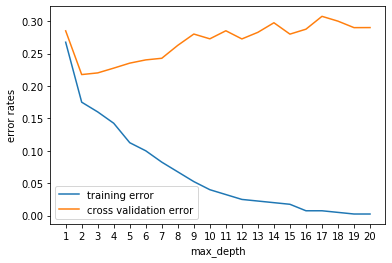

In [79]:
plt.plot(max_depth, train_error, label = 'training error')
plt.plot(max_depth, mean_cv_error, label = 'cross validation error')
plt.legend()
plt.ylabel('error rates')
plt.xlabel('max_depth')
plt.xticks(range(1,21,1))
plt.show()

From the plot, we can see that the higher the max_depth, the lower the training error. However, the validation error is lowest when max_depth equals 2, and then increases again with higher max_depth. Therefore, we choose max_depth = 2

In [80]:
tree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
print(f'The test error is: {1-tree_model.score(X_test, y_test): .3f}')

The test error is:  0.180


## Random Forest Classifier

In [48]:
rf =RandomForestClassifier(n_estimators=100, random_state = 123).fit(X_train, y_train)

##### Feature importance

In [49]:
pd.DataFrame({'feature': X_train.columns,
              'importance':rf.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
5,CGPA,0.367111
0,GRE Score,0.186069
1,TOEFL Score,0.146916
3,SOP,0.112951
2,University Rating,0.089964
4,LOR,0.073554
6,Research,0.023435


Cross validation error before dropping the feature 'Research'

In [50]:
rf = RandomForestClassifier(n_estimators=100, random_state = 123)
cv = cross_validate(rf, X_train, y_train, cv=5)
print(f"Cross-validation error = {1 - cv['test_score'].mean():.2f}")

Cross-validation error = 0.18


Check if the validation error does not decrease by removing the least important features

In [51]:
X_train_drop = X_train.drop(columns=['Research'])
cv = cross_validate(rf, X_train_drop, y_train, cv=5)
print(f"Cross-validation error = {1 - cv['test_score'].mean():.2f}")

Cross-validation error = 0.18


We see that the cross validation error is not affected by dropping the least important feature 'Research'. Hence we move ahead with the rest of the features. We also remove 'Research' from the test dataset.

In [52]:
X_test_drop = X_test.drop(columns=['Research'])

Fit the model again with the new training data after dropping least important features and check the model test score.

In [53]:
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state = 123).fit(X_train_drop, y_train)
1 - rf.score(X_test_drop, y_test)

0.17000000000000004

##### Scaling the numeric features

In [54]:
scaler = StandardScaler()
scaler.fit(X_train_drop)

X_train_scaled = scaler.transform(X_train_drop)
X_test_scaled = scaler.transform(X_test_drop)

Tune the hyper-parameter 'No. of trees'

In [55]:
mean_cv_train_rf = []
mean_cv_test_rf = []
for i in n_estimators:
    rf = RandomForestClassifier(n_estimators=i, max_depth=None, random_state = 123)
    cv_score_rf = cross_validate(rf, X_train_scaled, y_train, cv=10, return_train_score=True)
    #train_error.append(1 - rf.fit(X_train_scaled, y_train).score(X_train, y_train))
    mean_cv_train_rf.append((1 - cv_score_rf['train_score']).mean())
    mean_cv_test_rf.append((1 - cv_score_rf['test_score']).mean())

NameError: name 'n_estimators' is not defined

In [56]:
plt.close()
plt.plot(n_estimators, mean_cv_train_rf, label = 'training error')
plt.plot(n_estimators, mean_cv_test_rf, label = 'cross validation error')
plt.legend()
plt.ylabel('error rates')
plt.xlabel('n_estimators')
plt.title('Random Forest - Error rates')
plt.xticks(range(100,500,50))
plt.show()
plt.savefig('rf_cv.png')

NameError: name 'n_estimators' is not defined

Model test error

In [28]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, random_state = 123).fit(X_train_scaled, y_train)
print(f"Error on test data: {1- rf.score(X_test_scaled, y_test):.2f}")

Error on test data: 0.18


## kNN Classifier

#### Scaling the dataset

In [82]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Hyperparameter tuning

In [83]:
train_error = []
mean_cv_error = []
n_neighbors = []
for i in range(1,21,1):
    model_kNN = KNeighborsClassifier(n_neighbors = i)
    cv_score = cross_validate(model_kNN, X_train, y_train, cv=5, return_train_score=True)
    train_error.append(1-model_kNN.fit(X_train, y_train).score(X_train, y_train))
    mean_cv_error.append(1-cv_score['test_score'].mean())
    n_neighbors.append(i)

#### Plotting train & testing scores

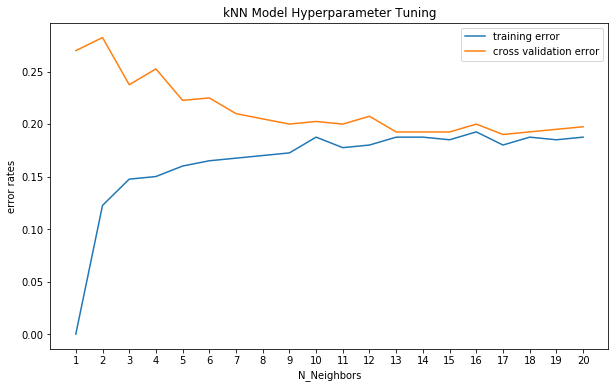

In [84]:
plt.figure(1,figsize = (10,6))
plt.plot(max_depth, train_error, label = 'training error')
plt.plot(max_depth, mean_cv_error, label = 'cross validation error')
plt.title('kNN Model Hyperparameter Tuning')
plt.legend()
plt.ylabel('error rates')
plt.xlabel('N_Neighbors')
plt.xticks(range(1,21,1))
plt.show()

In [85]:
kNN_model_final = KNeighborsClassifier(n_neighbors= 14).fit(X_train,y_train)
print(f'The test error is: {1-kNN_model_final.score(X_test, y_test): .3f}')

The test error is:  0.170
